<a href="https://colab.research.google.com/github/leonardoub/SCRIPT_PALERMO/blob/master/Network_classification_histology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy

#Load data

In [2]:
#load data from Drive
from google.colab import drive
drive.mount('/gdrive')
#%cd /gdrive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [0]:
train_dataset_path = '/gdrive/My Drive/AIM_PA/database_training2.csv'
test_dataset_path = '/gdrive/My Drive/AIM_PA/database_nostro_without_nan.csv'

In [0]:
df_train = pd.read_csv(train_dataset_path)
df_test = pd.read_csv(test_dataset_path)

In [0]:
df_train.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_test.rename(columns={'Survival.time (months)':'Surv_time_months'}, inplace=True)

In [0]:
df_train.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)
df_test.rename(columns={'Overall.Stage':'Overall_Stage'}, inplace=True)

In [0]:
train_data = df_train.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
test_data = df_test.drop(['Histology', 'Surv_time_months', 'OS', 'deadstatus.event','Overall_Stage'], axis=1)

In [0]:
train_labels = df_train.Histology

In [0]:
test_labels = df_test.Histology

##Z score dei dati

In [0]:
mean = train_data.mean(axis=0)
train_data_stand = train_data - mean
std = train_data.std(axis=0)
train_data_stand /= std

In [0]:
test_data_stand = test_data - mean
test_data_stand /= std

##Vettorizzare i label

In [0]:
word_index={'adenocarcinoma':0, 'large cell':1, 'squamous cell carcinoma':2}

In [0]:
train_labels_dec = [word_index[label] for label in train_labels]

In [0]:
test_labels_dec = [word_index[label] for label in test_labels]

In [17]:
from keras.utils.np_utils import to_categorical

Using TensorFlow backend.


In [0]:
one_hot_train_labels = to_categorical(train_labels_dec)
one_hot_test_labels = to_categorical(test_labels_dec)

#PCA

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(n_components=0.85, svd_solver='full')

In [21]:
pca.fit(train_data_stand)

PCA(copy=True, iterated_power='auto', n_components=0.85, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

In [0]:
train_data_stand_pca = pca.transform(train_data_stand)
test_data_stand_pca = pca.transform(test_data_stand)

In [23]:
train_data_stand_pca.shape

(131, 7)

#Building Network

In [0]:
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras import layers

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(4, activation='relu', input_shape=(7,)))
  #model.add(layers.Dense(7, activation='relu'))
  #model.add(layers.Dropout(rate=0.2))

  model.add(layers.Dense(3, activation='softmax'))

  sgd = SGD(lr=0.001, momentum=0.5)
  
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [0]:
from sklearn.model_selection import StratifiedKFold

In [30]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf.get_n_splits(train_data_stand_pca, train_labels_dec)

10

In [31]:
for train_index, test_index in skf.split(train_data_stand_pca, train_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   2   3   4   5   6   8  10  11  12  13  14  15  16  17  18  20
  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  46  47  48  49  50  51  52  55  56  57  58  59  60
  61  62  63  64  65  67  68  69  70  71  72  73  74  75  76  77  78  79
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  96  97  98  99
 100 101 102 103 104 106 107 108 109 110 113 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130] TEST: [  7   9  19  28  45  53  54  66  80  95 105 111 112 114]
TRAIN: [  1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  45  46  47  48  49  50  52  53  54  55  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 117
 118 119

In [32]:
train_labels_dec[125]

2

In [0]:
from keras.utils import to_categorical


In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

In [0]:
import keras

In [36]:
num_epochs = 100
all_acc_histories = []
all_loss_histories = []
all_val_acc_histories = []
all_val_loss_histories = []

for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_pca[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  model = build_model()
  history = model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=8)
  
  acc_history = history.history['acc']
  all_acc_histories.append(acc_history)

  loss_history = history.history['loss']
  all_loss_histories.append(loss_history)

  acc_val_history = history.history['val_acc']
  all_val_acc_histories.append(acc_val_history)

  loss_val_history = history.history['val_loss']
  all_val_loss_histories.append(loss_val_history)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 117 samples, validate on 14 samples
Epoch 1/100





117/117 [==============================] - 1s 5ms/step - loss: 3.9928 - acc: 0.1026 - val_loss: 2.6886 - val_acc: 0.2143
Epoch 2/100
117/117 [==============================] - 0s 275us/step - loss: 3.6038 - acc: 0.1026 - val_loss: 2.4447 - val_acc: 0.2143
Epoch 3/100
117/117 [==============================] - 0s 177us/step - loss: 3.2548 - acc: 0.1111 - val_loss: 2.2219 - val_acc: 0.2143
Epoch 4/100
117/117 [==============================] - 0s 201us/step - loss: 2.9598 - acc: 0.1197 - val_loss: 2.0345 - val_acc: 0.2143
Epoch 5/100
117/117 [==============================] - 0s 189us/step - loss: 2.7026 - acc: 0.1282 - val_loss: 1.8655 - val_acc: 0.2857
Epoch 6/100
117/117 [==============================] - 0s 170us/step - loss: 2.4746 - acc: 0.1368 - val_loss: 1.7351 - val_acc: 0.2857
Epoch 7/100
117/117 [===================

In [0]:
history_dict = history.history

In [38]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [39]:
len(all_acc_histories[2])

100

In [0]:
average_acc_history = [np.mean([x[i] for x in all_acc_histories]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche
average_loss_history = [np.mean([x[i] for x in all_loss_histories]) for i in range(num_epochs)]
average_val_acc_history = [np.mean([x[i] for x in all_val_acc_histories]) for i in range(num_epochs)]
average_val_loss_history = [np.mean([x[i] for x in all_val_loss_histories]) for i in range(num_epochs)]


In [41]:
len(average_val_acc_history)

100

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

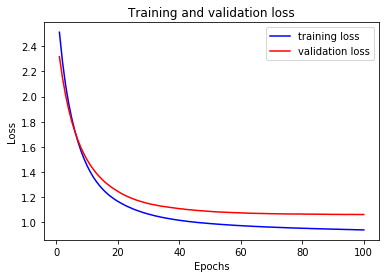

In [44]:
plt.plot(epochs, average_loss_history, 'b', label='training loss')
plt.plot(epochs, average_val_loss_history, 'r', label='validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

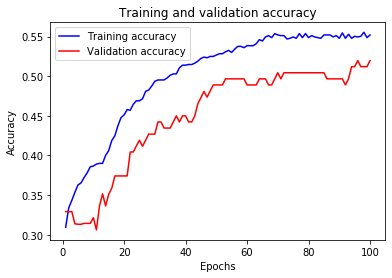

In [45]:
plt.plot(epochs, average_acc_history, 'b', label='Training accuracy')
plt.plot(epochs, average_val_acc_history, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

#Performances on test set

In [46]:
 model = build_model()
 model.fit(train_data_stand_pca, one_hot_train_labels, epochs= num_epochs, batch_size=8, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand_pca, one_hot_test_labels)
  

Epoch 1/100
131/131 [==============================] - 0s 4ms/step - loss: 2.7938 - acc: 0.2137
Epoch 2/100
131/131 [==============================] - 0s 203us/step - loss: 2.4296 - acc: 0.2214
Epoch 3/100
131/131 [==============================] - 0s 169us/step - loss: 2.1555 - acc: 0.2214
Epoch 4/100
131/131 [==============================] - 0s 175us/step - loss: 1.9364 - acc: 0.2290
Epoch 5/100
131/131 [==============================] - 0s 160us/step - loss: 1.7579 - acc: 0.2443
Epoch 6/100
131/131 [==============================] - 0s 147us/step - loss: 1.6101 - acc: 0.2901
Epoch 7/100
131/131 [==============================] - 0s 155us/step - loss: 1.5001 - acc: 0.3282
Epoch 8/100
131/131 [==============================] - 0s 156us/step - loss: 1.4195 - acc: 0.3435
Epoch 9/100
131/131 [==============================] - 0s 173us/step - loss: 1.3570 - acc: 0.3435
Epoch 10/100
131/131 [==============================] - 0s 166us/step - loss: 1.3130 - acc: 0.3893
Epoch 11/100
131/131 

In [47]:
model.metrics_names

['loss', 'acc']

In [48]:
test_acc


0.17647058823529413

#Prova con LDA

##LDA

In [0]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [0]:
lda = LinearDiscriminantAnalysis(n_components=3)

In [74]:
train_data_stand_lda = lda.fit(train_data_stand, train_labels_dec).transform(train_data_stand)

/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:463: ChangedBehaviorWarning: n_components cannot be larger than min(n_features, n_classes - 1). Using min(n_features, n_classes - 1) = min(107, 3 - 1) = 2 components.
  ChangedBehaviorWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/discriminant_analysis.py:469: FutureWarning: In version 0.23, setting n_components > min(n_features, n_classes - 1) will raise a ValueError. You should set n_components to None (default), or a value smaller or equal to min(n_features, n_classes - 1).
  warnings.warn(future_msg, FutureWarning)


In [75]:
train_data_stand_lda.shape

(131, 2)

In [0]:
test_data_stand_lda = lda.transform(test_data_stand)

##Building Network

In [0]:
from keras import layers
from keras.preprocessing import sequence

In [0]:
from keras import layers

In [0]:
from keras import regularizers

In [0]:
from keras.optimizers import SGD

In [0]:
def build_model():
  model = keras.models.Sequential()
  model.add(layers.Dense(4, activation='relu', input_shape=(2,)))
  #model.add(layers.Dense(7, activation='relu'))
  #model.add(layers.Dropout(rate=0.2))

  model.add(layers.Dense(3, activation='softmax'))

  sgd = SGD(lr=0.001, momentum=0.5)
  
  model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

##Stratified k-fold

This cross-validation object is a variation of KFold that returns stratified folds. The folds are made by preserving the percentage of samples for each class.

In [0]:
from sklearn.model_selection import StratifiedKFold

In [82]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
skf.get_n_splits(train_data_stand_lda, train_labels_dec)

10

In [83]:
for train_index, test_index in skf.split(train_data_stand_lda, train_labels_dec):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [  0   1   2   3   4   5   6   8  10  11  12  13  14  15  16  17  18  20
  21  22  23  24  25  26  27  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  46  47  48  49  50  51  52  55  56  57  58  59  60
  61  62  63  64  65  67  68  69  70  71  72  73  74  75  76  77  78  79
  81  82  83  84  85  86  87  88  89  90  91  92  93  94  96  97  98  99
 100 101 102 103 104 106 107 108 109 110 113 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130] TEST: [  7   9  19  28  45  53  54  66  80  95 105 111 112 114]
TRAIN: [  1   2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  45  46  47  48  49  50  52  53  54  55  58  59  60
  61  62  63  64  65  66  67  68  69  70  71  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  91  92  93  94  95  96  97  98
  99 100 101 102 103 104 105 106 107 108 110 111 112 113 114 115 116 117
 118 119

In [84]:
train_labels_dec[125]

2

In [0]:
from keras.utils import to_categorical


In [0]:
#for train_index, val_index in skf.split(train_data_stand_pca, train_labels_dec):
 
#  partial_train_data = np.array([train_data_stand_pca[i] for i in train_index])
#  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])

#  val_data = np.array([train_data_stand_pca[i] for i in val_index])
#  val_targets = np.array([train_labels_dec[i] for i in val_index])

#  one_hot_partial_train_targets = to_categorical(partial_train_targets)
#  one_hot_val_targets = to_categorical(val_targets)

#  model = build_model()
#  model.fit(partial_train_data, one_hot_partial_train_targets, epochs = num_epochs, batch_size=1)

#  val_loss, val_accuracy = model.evaluate(val_data, one_hot_val_targets)
#  all_scores.append(val_accuracy)
#I parametri per la valutazione vengono calcolati una volta per ogni k-fold, per ogni set di validazione, quindi k volte

C'è un problema: keras.utils.to_categorical produces a one-hot encoded class vector, i.e. the multilabel-indicator mentioned in the error message. StratifiedKFold is not designed to work with such input; i.e. your y must be a 1-D array of your class labels.
Essentially, what you have to do is simply to invert the order of the operations: split first (using your intial y_train), and convert to_categorical afterwards.

In [0]:
import keras

In [90]:
num_epochs = 100
all_acc_histories_lda = []
all_loss_histories_lda = []
all_val_acc_histories_lda = []
all_val_loss_histories_lda = []

for train_index, val_index in skf.split(train_data_stand_lda, train_labels_dec):
 
  partial_train_data = np.array([train_data_stand_lda[i] for i in train_index])
  partial_train_targets = np.array([train_labels_dec[i] for i in train_index])
  
  val_data = np.array([train_data_stand_lda[i] for i in val_index])
  val_targets = np.array([train_labels_dec[i] for i in val_index])

  one_hot_partial_train_targets = to_categorical(partial_train_targets)
  one_hot_val_targets = to_categorical(val_targets)

 
  model = build_model()
  history = model.fit(partial_train_data, one_hot_partial_train_targets, validation_data=(val_data, one_hot_val_targets), 
                      epochs=num_epochs, batch_size=8)
  
  acc_history = history.history['acc']
  all_acc_histories_lda.append(acc_history)

  loss_history = history.history['loss']
  all_loss_histories_lda.append(loss_history)

  acc_val_history = history.history['val_acc']
  all_val_acc_histories_lda.append(acc_val_history)

  loss_val_history = history.history['val_loss']
  all_val_loss_histories_lda.append(loss_val_history)
  

#I parametri per la valutazione vengono calcolati per ogni epoca, quindi num_epochs volte. 
#Il tutto viene ripetuto un numero di volte pari a n_splits.
#Si ottiene una lista con n_splits elementi ciascuno dei quali è una lista lunga num_epochs,
#ogni elemento può essere uno fra questi: dict_keys(['val_loss', 'val_acc', 'loss', 'acc']) 

Train on 117 samples, validate on 14 samples
Epoch 1/100
117/117 [==============================] - 1s 5ms/step - loss: 1.3600 - acc: 0.3932 - val_loss: 1.3911 - val_acc: 0.4286
Epoch 2/100
117/117 [==============================] - 0s 199us/step - loss: 1.2576 - acc: 0.4103 - val_loss: 1.2856 - val_acc: 0.4286
Epoch 3/100
117/117 [==============================] - 0s 183us/step - loss: 1.1627 - acc: 0.4103 - val_loss: 1.1837 - val_acc: 0.4286
Epoch 4/100
117/117 [==============================] - 0s 173us/step - loss: 1.0784 - acc: 0.6581 - val_loss: 1.0957 - val_acc: 0.8571
Epoch 5/100
117/117 [==============================] - 0s 182us/step - loss: 1.0007 - acc: 0.8547 - val_loss: 1.0164 - val_acc: 0.8571
Epoch 6/100
117/117 [==============================] - 0s 211us/step - loss: 0.9295 - acc: 0.8547 - val_loss: 0.9381 - val_acc: 0.8571
Epoch 7/100
117/117 [==============================] - 0s 173us/step - loss: 0.8646 - acc: 0.8547 - val_loss: 0.8695 - val_acc: 0.8571
Epoch 8/100


In [91]:
val_data

array([[-2.46815712,  2.41613978],
       [-2.04213808, -1.20055142],
       [-2.26598031, -2.51797746],
       [-1.62561816, -1.97201226],
       [-2.12949607, -1.76064808],
       [-1.32853889, -2.05415965],
       [-1.86366758, -1.96105974],
       [ 3.1426414 ,  0.23838493],
       [ 2.76856724,  0.87507987],
       [ 3.33006485,  0.80105572],
       [ 3.99255757,  0.1366972 ],
       [ 2.79798337,  1.20174003],
       [ 1.67824072,  0.59967329]])

In [0]:
history_dict = history.history

In [93]:
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [94]:
len(all_acc_histories[2])

100

In [0]:
average_acc_history_lda = [np.mean([x[i] for x in all_acc_histories_lda]) for i in range(num_epochs)]
#media per epoca degli score ottenuti per tutte le k-fold
#per ogni k-fold di fanno num_epoch epoche, la media viene fatta prendendo gli score di tutti i k-fold relativi ad una data epoca,
#e si fa questo per tutte le epoche
average_loss_history_lda = [np.mean([x[i] for x in all_loss_histories_lda]) for i in range(num_epochs)]
average_val_acc_history_lda = [np.mean([x[i] for x in all_val_acc_histories_lda]) for i in range(num_epochs)]
average_val_loss_history_lda = [np.mean([x[i] for x in all_val_loss_histories_lda]) for i in range(num_epochs)]


In [96]:
len(average_val_acc_history)

100

##Plotting training and validation loss

In [0]:
import matplotlib.pyplot as plt

In [0]:
epochs = range(1, num_epochs+1)

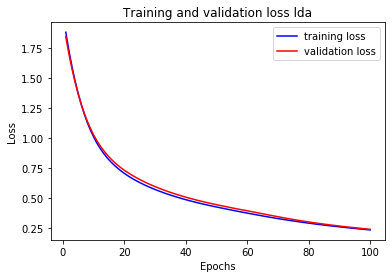

In [99]:
plt.plot(epochs, average_loss_history_lda, 'b', label='training loss')
plt.plot(epochs, average_val_loss_history_lda, 'r', label='validation loss')
plt.title('Training and validation loss lda')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

##Plotting train and validation accuracy

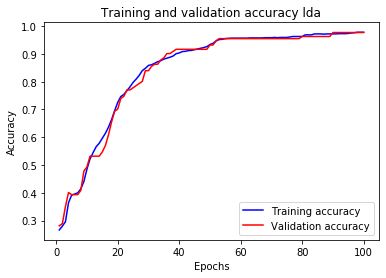

In [100]:
plt.plot(epochs, average_acc_history_lda, 'b', label='Training accuracy')
plt.plot(epochs, average_val_acc_history_lda, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy lda')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend() 

##Performances on test set

In [102]:
 model = build_model()
 model.fit(train_data_stand_lda, one_hot_train_labels, epochs= num_epochs, batch_size=8, shuffle=True)
 test_loss, test_acc = model.evaluate(test_data_stand_lda, one_hot_test_labels)
  

Epoch 1/100
131/131 [==============================] - 1s 7ms/step - loss: 1.1533 - acc: 0.4504
Epoch 2/100
131/131 [==============================] - 0s 200us/step - loss: 1.0981 - acc: 0.4656
Epoch 3/100
131/131 [==============================] - 0s 189us/step - loss: 1.0497 - acc: 0.4733
Epoch 4/100
131/131 [==============================] - 0s 197us/step - loss: 1.0067 - acc: 0.4733
Epoch 5/100
131/131 [==============================] - 0s 164us/step - loss: 0.9679 - acc: 0.4809
Epoch 6/100
131/131 [==============================] - 0s 197us/step - loss: 0.9340 - acc: 0.4885
Epoch 7/100
131/131 [==============================] - 0s 155us/step - loss: 0.9014 - acc: 0.4962
Epoch 8/100
131/131 [==============================] - 0s 188us/step - loss: 0.8720 - acc: 0.5496
Epoch 9/100
131/131 [==============================] - 0s 172us/step - loss: 0.8448 - acc: 0.6870
Epoch 10/100
131/131 [==============================] - 0s 158us/step - loss: 0.8199 - acc: 0.6947
Epoch 11/100
131/131 

In [103]:
model.metrics_names

['loss', 'acc']

In [104]:
test_acc


0.14705882352941177

Si comporta molto bene in training e in validation ma si comporta male in test